# Sort candidate pulse sequences

From the job output, use regex to delete all lines that don't contain candidate sequences via `^((?!candidate pulse sequence).)*$`.

In [1]:
import sys
import os
import re
import pandas as pd

In [53]:
path = '../../data/2021-02/20210213-191154/'

In [54]:
candidates = []
with open(os.path.join(path, 'candidates.txt')) as file:
    for line in file:
        candidates.append(line)

In [55]:
c2 = []
for c in candidates:
    try:
        m = re.search(r'(.*?) candidate pulse sequence from \d+ \((.*?), array\((.*?)\), (.*?)\)\n', c)
        c2.append({
            'timestamp': m.group(1),
            'sequence': m.group(2),
            'last_pulse': m.group(3),
            'value': float(m.group(4))
        })
    except Exception as e:
        print(c)

In [56]:
len(c2)

25

In [57]:
df = pd.DataFrame(c2)

array([[<AxesSubplot:title={'center':'value'}>]], dtype=object)

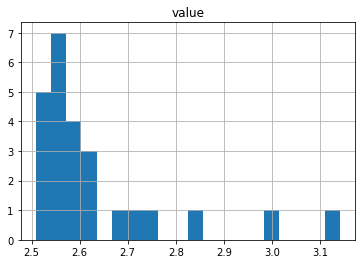

In [58]:
df.hist('value', bins=20)

In [59]:
df.sort_values('value', ascending=False, inplace=True)
# df

In [60]:
df.to_csv(os.path.join(path, 'candidates_sorted.csv'))